##### **Name:** Rohan Karthikeyan
##### **Roll Number:** MDS202226

In the second task of our midsemester exam, we will be using ML methods for traffic classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

# Set a dataframe for holding results
model_performance = pd.DataFrame(columns = ['Precision', 'Accuracy'])
pd.set_option('display.max_columns', 50)

### Data Preparation

In [2]:
%%time
# Because the data doesn't have headers, we import it from the features file:
headers = pd.read_csv('../input/features/NUSW-NB15_features.csv')['Name'].tolist()

flow_data = pd.DataFrame()
file_path = '../input/unsw-nb15/UNSW-NB15_'
for i in range(1, 5):
    path = file_path + str(i) + '.csv'
    subset = pd.read_csv(path, header=None)
    flow_data = pd.concat([flow_data, subset])

# Add the column names
flow_data.columns = headers
flow_data.reset_index(drop=True, inplace=True)
flow_data

<timed exec>:8: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
<timed exec>:8: DtypeWarning: Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 13.4 s, sys: 3.49 s, total: 16.9 s
Wall time: 24.7 s


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,Sload,Dload,Spkts,Dpkts,swin,dwin,stcpb,dtcpb,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,29,0,0,dns,500473.937500,621800.937500,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.017000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,29,0,0,-,87676.085940,50480.171880,4,4,0,0,0,0,132,76,0,0,9.891010,10.682733,1421927414,1421927414,7.005000,7.564333,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,29,0,0,dns,521894.531300,636282.375000,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.017000,0.013000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,29,0,0,dns,436724.562500,542597.187500,2,2,0,0,0,0,66,82,0,0,0.000000,0.000000,1421927414,1421927414,0.043000,0.014000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,29,0,0,dns,499572.250000,609067.562500,2,2,0,0,0,0,73,89,0,0,0.000000,0.000000,1421927414,1421927414,0.005000,0.003000,0.000000,0.000000,0.000000,0,0,0.0,0.0,0,7,9,1,1,1,1,1,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540042,59.166.0.5,33094,149.171.126.7,43433,tcp,FIN,0.087306,320,1828,31,29,1,2,ftp-data,24465.671880,146610.765600,6,8,255,255,4035116044,222196311,53,229,0,0,1221.136547,30.096029,1424262068,1424262069,17.394400,12.405143,0.000608,0.000468,0.000140,0,0,NaN,NaN,,1,2,3,3,1,1,3,NaN,0
2540043,59.166.0.7,20848,149.171.126.4,21,tcp,CON,0.365058,456,346,31,29,2,2,ftp,8743.816406,6333.240234,8,6,255,255,1529727621,185369967,57,58,0,0,3961.093354,129.038367,1424262068,1424262069,51.976999,72.915602,0.000609,0.000477,0.000132,0,0,NaN,2.0,2,2,2,2,2,2,2,2,NaN,0
2540044,59.166.0.3,21511,149.171.126.9,21,tcp,CON,6.335154,1802,2088,31,29,7,9,ftp,2204.839844,2549.582764,32,30,255,255,497208793,889904111,56,70,0,0,13233.728560,379.052750,1424262062,1424262069,204.359814,214.372375,0.000617,0.000485,0.000132,0,0,NaN,2.0,2,2,2,4,2,2,2,2,NaN,0
2540045,59.166.0.9,35433,149.171.126.0,80,tcp,CON,2.200934,3498,166054,31,29,2,57,http,12496.513670,598375.062500,58,116,255,255,1289728069,3436097151,60,1432,1,79745,2868.893137,1951.035944,1424262067,1424262069,38.609700,19.133826,0.000680,0.000541,0.000139,0,0,2.0,NaN,,1,1,2,4,2,2,2,NaN,0


#### Q0: What are the number of flows?

**Assumption:** I consider each record as an individual flow due to the lack of a flow ID.

In [3]:
# Find the number of records
print('There are {} flows in the dataset.'.format(len(flow_data)))

There are 2540047 flows in the dataset.


#### Q1: What is the duration of flows?

In [4]:
small = flow_data[['dur', 'Stime', 'Ltime']].copy()

# Convert epoch to date-time
small['Stime'] = pd.to_datetime(small['Stime'], unit='s')
small['Ltime'] = pd.to_datetime(small['Ltime'], unit='s')

# Difference in time durations
small['time_diff'] = (small['Ltime'] - small['Stime']).dt.seconds
small

,dur,Stime,Ltime,time_diff
0,0.001055,2015-01-22 11:50:14,2015-01-22 11:50:14,0
1,0.036133,2015-01-22 11:50:14,2015-01-22 11:50:14,0
2,0.001119,2015-01-22 11:50:14,2015-01-22 11:50:14,0
3,0.001209,2015-01-22 11:50:14,2015-01-22 11:50:14,0
4,0.001169,2015-01-22 11:50:14,2015-01-22 11:50:14,0
...,...,...,...,...
2540042,0.087306,2015-02-18 12:21:08,2015-02-18 12:21:09,1
2540043,0.365058,2015-02-18 12:21:08,2015-02-18 12:21:09,1
2540044,6.335154,2015-02-18 12:21:02,2015-02-18 12:21:09,7
2540045,2.200934,2015-02-18 12:21:07,2015-02-18 12:21:09,2


This shows us that the time difference is in seconds. Let us add up the entire duration.

In [5]:
# Sum up the `dur` column
num_hours = small['dur'].sum()/86400
print('The flows last for a total of {:.2f} hours.'.format(num_hours))

The flows last for a total of 19.37 hours.


#### Feature selection

In [6]:
# Columns with at least one null value
cols_with_missing = list(flow_data.columns[flow_data.isnull().any()])

# Find the number of NaNs in these columns
flow_data[cols_with_missing].isna().sum()

ct_flw_http_mthd    1348145
is_ftp_login        1429879
attack_cat          2218764
dtype: int64

More than half of the records have a NaN in these columns, so it is best to drop them.

And we remove some other unnecessary columns:
* We drop `srcip` and `dstip` because what service is used is seldom dependent on the source and destination IP addresses.
* We drop `swin` and `dwin` (source and destination TCP window advertisement values):
  * A simple check shows that both columns are same and the only unique values are 0 and 255;
* We drop `stcpb` and `dtcpb` (source and destination TCP base sequence numbers):
  * According to [this website](https://packetlife.net/blog/2010/jun/7/understanding-tcp-sequence-acknowledgment-numbers/), these are effectively random numbers;
* We drop `Stime` and `Ltime` because they are timestamps and won't be useful for prediction;
* We drop `tcprtt` because the docs say that it is a sum of the `synack` and `ackdat` columns;
* We drop `Label` because it's out of place for predicting the service type.

Should we retain `sport` and `dport` for predicting `service`? There is an almost one-to-one correspondence between the port numbers and service used, right?<br> 'Almost' because of possible port masquerading. We drop these as well.

In [7]:
to_drop = ['srcip', 'sport', 'dstip', 'dsport', 'swin', 'dwin', 'stcpb', 'dtcpb',
           'Stime', 'Ltime', 'tcprtt', 'ct_flw_http_mthd', 'is_ftp_login',
           'attack_cat', 'Label']
flow_data.drop(to_drop, axis=1, inplace=True)

Missing values in the `service` column are encoded by a `-`. We remove all such records.

In [8]:
# Move the target variable to last place
col = flow_data.pop('service')
flow_data = pd.concat([flow_data, col], axis=1)
flow_data = flow_data[flow_data['service'] != '-'].reset_index(drop=True)

flow_data

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Sintpkt,Dintpkt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,service
0,udp,CON,0.001055,132,164,31,29,0,0,500473.937500,621800.937500,2,2,66,82,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0,0,0,3,7,1,3,1,1,1,dns
1,udp,CON,0.001119,146,178,31,29,0,0,521894.531300,636282.375000,2,2,73,89,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0,0,0,12,8,1,2,2,1,1,dns
2,udp,CON,0.001209,132,164,31,29,0,0,436724.562500,542597.187500,2,2,66,82,0,0,0.000000,0.000000,0.043000,0.014000,0.000000,0.000000,0,0,0,6,9,1,1,1,1,1,dns
3,udp,CON,0.001169,146,178,31,29,0,0,499572.250000,609067.562500,2,2,73,89,0,0,0.000000,0.000000,0.005000,0.003000,0.000000,0.000000,0,0,0,7,9,1,1,1,1,1,dns
4,udp,CON,0.001134,132,164,31,29,0,0,465608.468800,578483.250000,2,2,66,82,0,0,0.000000,0.000000,0.017000,0.013000,0.000000,0.000000,0,0,0,12,7,1,2,2,1,1,dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293645,tcp,FIN,0.087306,320,1828,31,29,1,2,24465.671880,146610.765600,6,8,53,229,0,0,1221.136547,30.096029,17.394400,12.405143,0.000468,0.000140,0,0,,1,2,3,3,1,1,3,ftp-data
1293646,tcp,CON,0.365058,456,346,31,29,2,2,8743.816406,6333.240234,8,6,57,58,0,0,3961.093354,129.038367,51.976999,72.915602,0.000477,0.000132,0,0,2,2,2,2,2,2,2,2,ftp
1293647,tcp,CON,6.335154,1802,2088,31,29,7,9,2204.839844,2549.582764,32,30,56,70,0,0,13233.728560,379.052750,204.359814,214.372375,0.000485,0.000132,0,0,2,2,2,4,2,2,2,2,ftp
1293648,tcp,CON,2.200934,3498,166054,31,29,2,57,12496.513670,598375.062500,58,116,60,1432,1,79745,2868.893137,1951.035944,38.609700,19.133826,0.000541,0.000139,0,0,,1,1,2,4,2,2,2,http


Starting with 2.54M records, we are now left with ~1.29M records, a 49% drop!

#### Check distribution of numeric columns

In [9]:
# Encode blanks in the `ct_ftp_cmd` column with 0
flow_data.ct_ftp_cmd = flow_data.ct_ftp_cmd.replace(' ', 0)

# Convert it to numeric
flow_data['ct_ftp_cmd'] = pd.to_numeric(flow_data['ct_ftp_cmd'], errors='coerce')

In [10]:
numeric_cols = flow_data.select_dtypes(include=np.number).columns.tolist()
# Remove `is_sm_ips_ports` because it is a binary variable
del numeric_cols[-10]

print(numeric_cols)

['dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Sintpkt', 'Dintpkt', 'synack', 'ackdat', 'ct_state_ttl', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']


In [11]:
flow_data[numeric_cols].describe()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Sintpkt,Dintpkt,synack,ackdat,ct_state_ttl,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
count,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06
mean,4.428769e-01,4.684236e+03,2.074827e+04,7.483352e+01,2.555971e+01,3.323393e+00,9.127157e+00,6.122455e+07,5.509887e+05,1.889283e+01,2.429477e+01,1.452831e+02,1.642972e+02,1.520179e-01,8.035386e+03,1.649806e+03,1.007076e+03,1.955914e+01,1.640846e+01,1.905447e-03,1.828240e-03,3.540007e-01,4.031693e-02,1.107138e+01,1.106465e+01,8.878987e+00,9.235254e+00,7.480563e+00,5.767279e+00,1.082311e+01
std,2.080845e+00,7.215648e+04,1.453205e+05,8.256675e+01,4.026245e+01,2.789001e+01,5.043779e+01,1.371051e+08,1.550018e+06,7.452103e+01,1.043309e+02,1.837696e+02,2.661621e+02,4.617078e-01,6.521485e+04,8.533899e+03,3.294200e+03,1.667161e+02,1.657453e+02,1.205281e-02,1.191933e-02,7.487176e-01,2.564595e-01,1.413693e+01,1.413661e+01,1.022120e+01,1.018306e+01,1.079446e+01,7.664580e+00,1.430124e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,9.000000e-06,1.460000e+02,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.785701e+05,0.000000e+00,2.000000e+00,0.000000e+00,5.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,1.067000e-03,2.640000e+02,1.780000e+02,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00,5.637066e+05,7.466993e+04,2.000000e+00,2.000000e+00,7.300000e+01,8.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,8.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
75%,2.358217e-01,1.580000e+03,3.380000e+03,6.000000e+01,2.900000e+01,3.000000e+00,5.000000e+00,5.700000e+07,6.545455e+05,1.400000e+01,1.800000e+01,1.320000e+02,8.900000e+01,0.000000e+00,0.000000e+00,7.840190e+02,4.491281e+01,9.656205e+00,1.055867e+01,5.170000e-04,1.310000e-04,0.000000e+00,0.000000e+00,2.000000e+01,2.000000e+01,1.300000e+01,1.300000e+01,1.300000e+01,1.000000e+01,2.000000e+01
max,5.999953e+01,1.435577e+07,1.465753e+07,2.550000e+02,2.540000e+02,5.319000e+03,5.507000e+03,2.304000e+09,2.337861e+07,1.064600e+04,1.101800e+04,1.500000e+03,1.500000e+03,1.720000e+02,6.558056e+06,1.107490e+06,7.812211e+05,4.210053e+04,4.210050e+04,5.207840e-01,1.424061e+00,6.000000e+00,8.000000e+00,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,3.800000e+01,6.700000e+01


All 32 numeric features are nonnegative and their histograms are right-skewed, resembling an exponential distribution.

Hence, ***a log-transformation is recommended***.

#### Apply log-transformation to numeric columns

We first check the number of unique values in each column. This is because even though columns like `sttl` and `trans_depth` are numeric, they take on very few unique values -- they essentially behave like categorical variables.

Hence, let's apply a log-transformation to only those numeric columns which have more than 15 unique values.

In [12]:
flow_data[numeric_cols].apply(lambda x: len(x.unique()))

dur                 301622
sbytes                8061
dbytes                8213
sttl                     8
dttl                     7
sloss                  431
dloss                  481
Sload               379548
Dload               370577
Spkts                  684
Dpkts                  744
smeansz               1274
dmeansz               1380
trans_depth             14
res_bdy_len           2891
Sjit                499181
Djit                488072
Sintpkt             377861
Dintpkt             369758
synack               31178
ackdat               28504
ct_state_ttl             6
ct_ftp_cmd               8
ct_srv_src              65
ct_srv_dst              65
ct_dst_ltm              62
ct_src_ ltm             62
ct_src_dport_ltm        62
ct_dst_sport_ltm        38
ct_dst_src_ltm          65
dtype: int64

In [13]:
for feature in numeric_cols:
    if flow_data[feature].nunique() > 15:
        flow_data[feature] = np.log1p(flow_data[feature])

# Check distribution of numeric cols now
flow_data[numeric_cols[:7]].describe()

,dur,sbytes,dbytes,sttl,dttl,sloss,dloss
count,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06,1.293650e+06
mean,2.055805e-01,6.248693e+00,4.793328e+00,7.483352e+01,2.555971e+01,6.894868e-01,7.935909e-01
std,4.174756e-01,1.763651e+00,3.752295e+00,8.256675e+01,4.026245e+01,1.007922e+00,1.192960e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.999960e-06,4.990433e+00,0.000000e+00,3.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.066431e-03,5.579730e+00,5.187386e+00,3.100000e+01,2.900000e+01,0.000000e+00,0.000000e+00
75%,2.117361e-01,7.365813e+00,8.125927e+00,6.000000e+01,2.900000e+01,1.386294e+00,1.791759e+00
max,4.110866e+00,1.647966e+01,1.650046e+01,2.550000e+02,2.540000e+02,8.579229e+00,8.613957e+00


We can see the transformation has been effected for `sbytes` but not for `sttl`, which has less than 10 unique columns.

#### Encoding the categorical target variable, `service`

We use one-hot encoding as none of the categorical features: `proto` or `state` are ordinal.

In [14]:
le = LabelEncoder()
flow_data['service'] = le.fit_transform(flow_data['service'])
flow_data

,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Sintpkt,Dintpkt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,service
0,udp,CON,0.001054,4.890349,5.105945,31,29,0.000000,0.000000,13.123313,13.340377,1.098612,1.098612,4.204693,4.418841,0,0.000000,0.000000,0.000000,0.016857,0.012916,0.000000,0.000000,0,0,0,1.386294,2.079442,0.693147,1.386294,0.693147,0.693147,0.693147,1
1,udp,CON,0.001118,4.990433,5.187386,31,29,0.000000,0.000000,13.165223,13.363399,1.098612,1.098612,4.304065,4.499810,0,0.000000,0.000000,0.000000,0.016857,0.012916,0.000000,0.000000,0,0,0,2.564949,2.197225,0.693147,1.098612,1.098612,0.693147,0.693147,1
2,udp,CON,0.001208,4.890349,5.105945,31,29,0.000000,0.000000,12.987060,13.204124,1.098612,1.098612,4.204693,4.418841,0,0.000000,0.000000,0.000000,0.042101,0.013903,0.000000,0.000000,0,0,0,1.945910,2.302585,0.693147,0.693147,0.693147,0.693147,0.693147,1
3,udp,CON,0.001168,4.990433,5.187386,31,29,0.000000,0.000000,13.121510,13.319686,1.098612,1.098612,4.304065,4.499810,0,0.000000,0.000000,0.000000,0.004988,0.002996,0.000000,0.000000,0,0,0,2.079442,2.302585,0.693147,0.693147,0.693147,0.693147,0.693147,1
4,udp,CON,0.001133,4.890349,5.105945,31,29,0.000000,0.000000,13.051103,13.268167,1.098612,1.098612,4.204693,4.418841,0,0.000000,0.000000,0.000000,0.016857,0.012916,0.000000,0.000000,0,0,0,2.564949,2.079442,0.693147,1.098612,1.098612,0.693147,0.693147,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293645,tcp,FIN,0.083703,5.771441,7.511525,31,29,0.693147,1.098612,10.105067,11.895543,1.945910,2.197225,3.988984,5.438079,0,0.000000,7.108356,3.437080,2.912046,2.595638,0.000468,0.000140,0,0,0,0.693147,1.098612,1.386294,1.386294,0.693147,0.693147,1.386294,3
1293646,tcp,CON,0.311197,6.124683,5.849325,31,29,1.098612,1.098612,9.076216,8.753725,2.197225,1.945910,4.060443,4.077537,0,0.000000,8.284528,4.867830,3.969858,4.302924,0.000477,0.000132,0,0,2,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,1.098612,2
1293647,tcp,CON,1.992678,7.497207,7.644441,31,29,2.079442,2.302585,7.698864,7.844077,3.496508,3.433987,4.043051,4.262680,0,0.000000,9.490600,5.940310,5.324764,5.372369,0.000485,0.000132,0,0,2,1.098612,1.098612,1.609438,1.098612,1.098612,1.098612,1.098612,2
1293648,tcp,CON,1.163443,8.160232,12.020074,31,29,1.098612,4.060443,9.433285,13.301975,4.077537,4.762174,4.110874,7.267525,1,11.286602,7.962030,7.576628,3.679074,3.002401,0.000541,0.000139,0,0,0,0.693147,0.693147,1.098612,1.609438,1.098612,1.098612,1.098612,4


In [15]:
# Get the inverse transforms
values = le.inverse_transform(flow_data['service'])

# Mapping the encoded value
encoded_target_column = {}
for i in range(len(flow_data['service'])):
    encoded_target_column[flow_data['service'][i]] = values[i]

encoded_target_column = dict(sorted(encoded_target_column.items(), key=lambda x: x[0]))
print(encoded_target_column)

{0: 'dhcp', 1: 'dns', 2: 'ftp', 3: 'ftp-data', 4: 'http', 5: 'irc', 6: 'pop3', 7: 'radius', 8: 'smtp', 9: 'snmp', 10: 'ssh', 11: 'ssl'}


#### Other column transformations

In [16]:
# The nominative (unordered) categorical features
# Uses one-hot encoding
nominal_cols = ['proto', 'state']

# Define data preparation for the columns
t = [('num', MinMaxScaler(), numeric_cols),
     ('nom', OneHotEncoder(), nominal_cols)]

col_transform = ColumnTransformer(transformers=t, remainder='passthrough')

In [17]:
# Apply col_transform on dataset
X = flow_data.copy()
y = X.pop('service')

# Get number of features originally
feature_names = list(X.columns)

# Perform column transformations
X = col_transform.fit_transform(X)

# Add features from categorical columns to features list
for label in list(flow_data['state'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)

for label in list(flow_data['proto'].value_counts().index)[::-1][1:]:
    feature_names.insert(0,label)

#### Split data into train and test sets
We first obtain the number of records for each service: this will help us quantify the amount of imbalance in the data.

In [18]:
y.value_counts()

service
1     781668
4     206273
3     125783
8      81645
2      49090
10     47160
6       1533
0        172
11       142
9        113
7         40
5         31
Name: count, dtype: int64

The number of instances for each service are severely imbalanced. While `dns` (number 1) has 781K records, the `irc` service (number 5) has only 31 records!

**Conclusion:** Hence, we perform a stratified train-test split.

**NOTE:** I ***do not*** make a train-validation-test split as I'm not performing any hyperparameter tuning.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 15,
                                                    stratify = y)

### Decision Tree

We go with the decision tree model first because it performs automatic feature selection.<br>
That is, when it is building the tree, it only does so by splitting on features that cause the greatest increase in node purity, so features that a feature selection method would have eliminated aren’t used in the model.

In [20]:
%%time
dtree = DecisionTreeClassifier(criterion='gini', class_weight='balanced',
                               max_depth=5, max_features='log2')

# Get fitted model
model1 = dtree.fit(X_train, y_train)
# Get predictions
y_preds = model1.predict(X_test)

CPU times: user 1.99 s, sys: 61 ms, total: 2.06 s
Wall time: 2.06 s


In [21]:
# The 'weighted' option takes class imbalance into account
precision = precision_score(y_test, y_preds, average = 'weighted')
accuracy = model1.score(X_test, y_test)  # Return mean accuracy

print("Precision: "+ "{:.2%}".format(precision))
print("Accuracy: "+ "{:.2%}".format(accuracy))
model_performance.loc['Decision Tree'] = [precision, accuracy]

Precision: 96.10%
Accuracy: 93.10%


In [22]:
# The classification report gives the complete picture
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.10      0.97      0.18        34
           1       1.00      1.00      1.00    156334
           2       1.00      0.89      0.94      9818
           3       0.85      0.90      0.88     25156
           4       0.94      0.69      0.79     41255
           5       0.00      0.83      0.00         6
           6       0.24      0.99      0.39       307
           7       0.60      0.38      0.46         8
           8       1.00      0.94      0.97     16329
           9       0.13      0.96      0.24        23
          10       0.65      1.00      0.79      9432
          11       0.01      0.46      0.01        28

    accuracy                           0.93    258730
   macro avg       0.54      0.83      0.55    258730
weighted avg       0.96      0.93      0.94    258730



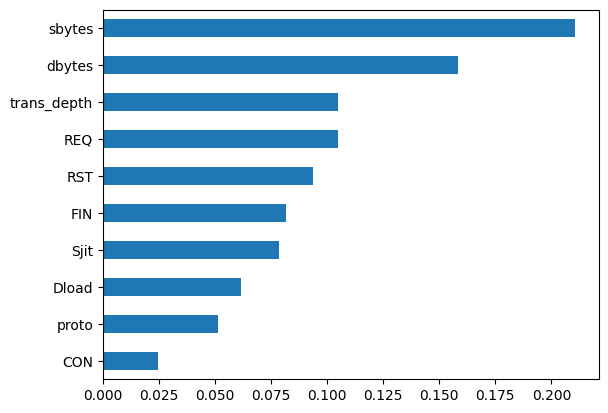

In [23]:
# See which features are important
feat_importances = pd.Series(model1.feature_importances_, index=feature_names)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()

### Histogram Gradient Boosting

According to the docs, this estimator is much faster than `GradientBoostingClassifier` for big datasets ($n_{\text{samples}} \geq 10000$).

In [24]:
%%time
our_scorer = make_scorer(precision_score, average='weighted')

# max_depth=1 uses a DTree of depth 1
histgbc = HistGradientBoostingClassifier(max_depth=1, class_weight='balanced',
                                         scoring=our_scorer, learning_rate=0.1)

# Get fitted model
model2 = histgbc.fit(X_train, y_train)
# Get predictions
y_preds = model2.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 9min 23s, sys: 1.13 s, total: 9min 24s
Wall time: 2min 30s


In [25]:
precision = precision_score(y_test, y_preds, average = 'weighted')
accuracy = model2.score(X_test, y_test)

print("Precision: "+ "{:.2%}".format(precision))
print("Accuracy: "+ "{:.2%}".format(accuracy))
model_performance.loc['Hist. GrBoost'] = [precision, accuracy]

Precision: 99.87%
Accuracy: 99.32%


In [26]:
# The classification report gives the complete picture
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.07      0.88      0.13        34
           1       1.00      1.00      1.00    156334
           2       1.00      0.99      0.99      9818
           3       0.99      0.99      0.99     25156
           4       1.00      0.99      0.99     41255
           5       0.02      1.00      0.04         6
           6       0.91      1.00      0.95       307
           7       0.06      1.00      0.11         8
           8       1.00      1.00      1.00     16329
           9       0.19      0.96      0.32        23
          10       1.00      1.00      1.00      9432
          11       0.05      1.00      0.09        28

    accuracy                           0.99    258730
   macro avg       0.61      0.98      0.63    258730
weighted avg       1.00      0.99      1.00    258730



### Logistic Regression

In [27]:
%%time
logreg = LogisticRegression(penalty = 'elasticnet', class_weight = 'balanced', random_state = 42,
                            solver = 'saga', l1_ratio = 0.25)

# Get fitted model
model3 = logreg.fit(X_train, y_train)
# Get predictions
y_preds = model3.predict(X_test)

CPU times: user 11min 16s, sys: 352 ms, total: 11min 16s
Wall time: 11min 16s


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
precision = precision_score(y_test, y_preds, average = 'weighted')
accuracy = model3.score(X_test, y_test)

print("Precision: {:.2%}".format(precision))
print("Accuracy: {:.2%}".format(accuracy))
model_performance.loc['Logistic Regression'] = [precision, accuracy]

Precision: 99.33%
Accuracy: 97.11%


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
# The classification report gives the complete picture
print(classification_report(y_test, y_preds))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.35      0.50      0.41        34
           1       1.00      1.00      1.00    156334
           2       0.98      0.92      0.95      9818
           3       0.99      0.95      0.97     25156
           4       0.99      0.90      0.94     41255
           5       0.00      0.00      0.00         6
           6       0.23      0.99      0.37       307
           7       0.04      0.50      0.07         8
           8       0.99      0.94      0.96     16329
           9       0.14      1.00      0.25        23
          10       0.98      0.99      0.98      9432
          11       0.01      1.00      0.01        28

    accuracy                           0.97    258730
   macro avg       0.56      0.81      0.58    258730
weighted avg       0.99      0.97      0.98    258730



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion

The histogram gradient boosting classifier achieved the highest precision and accuracy values (as a whole) and ran in a reasonable amount of time.<br>The other two models were at opposite ends: the decision tree model ran very quickly while the logistic regression model took > 10 minutes!

We observe that, in all three models, under-represented classes (e.g., classes 0, 5, 7, 9, and 11) achieve very low f1-scores as compared to the other classes.